In [2]:
import kagglehub

# Download the Chest X-Ray Masks and Labels dataset
path = kagglehub.dataset_download("nikhilpandey360/chest-xray-masks-and-labels")

print("Dataset downloaded to:", path)

100%|██████████| 9.58G/9.58G [02:04<00:00, 82.3MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/nikhilpandey360/chest-xray-masks-and-labels/versions/1


In [3]:
import os, glob
from sklearn.model_selection import train_test_split


path = "/root/.cache/kagglehub/datasets/nikhilpandey360/chest-xray-masks-and-labels/versions/1"

images_dir = f"{path}/data/Lung Segmentation/CXR_png"
masks_dir  = f"{path}/data/Lung Segmentation/Mask"
ann_dir    = f"{path}/data/Lung Segmentation/Annotation"

print("Images:", images_dir)
print("Masks:", masks_dir)
print("Annotations:", ann_dir)

#load img
all_images = sorted(glob.glob(os.path.join(images_dir, "*.png")))
print("Total images:", len(all_images))

# split
train_temp, test_files = train_test_split(all_images, test_size=0.10, random_state=42)
train_files, val_files = train_test_split(train_temp, test_size=0.20, random_state=42)

print(f"Train: {len(train_files)} | Val: {len(val_files)} | Test: {len(test_files)}")


Images: /root/.cache/kagglehub/datasets/nikhilpandey360/chest-xray-masks-and-labels/versions/1/data/Lung Segmentation/CXR_png
Masks: /root/.cache/kagglehub/datasets/nikhilpandey360/chest-xray-masks-and-labels/versions/1/data/Lung Segmentation/Mask
Annotations: /root/.cache/kagglehub/datasets/nikhilpandey360/chest-xray-masks-and-labels/versions/1/data/Lung Segmentation/Annotation
Total images: 800
Train: 576 | Val: 144 | Test: 80


In [4]:
from torch.utils.data import Dataset
from PIL import Image

# Filename frmat -  CHNCXR_0042_0.png menas  label = 0
def get_label_from_filename(path):
    return int(os.path.basename(path).split("_")[-1].split(".")[0])

class ChestXRayDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.files = file_list
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = self.files[idx]
        img = Image.open(path).convert("RGB")
        label = get_label_from_filename(path)

        if self.transform:
            img = self.transform(img)

        return img, label


In [5]:
from torchvision import transforms
from torch.utils.data import DataLoader

train_tf = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

val_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

train_ds = ChestXRayDataset(train_files, transform=train_tf)
val_ds   = ChestXRayDataset(val_files,   transform=val_tf)
test_ds  = ChestXRayDataset(test_files,  transform=val_tf)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=2)

print("Train:", len(train_ds))
print("Val:", len(val_ds))
print("Test:", len(test_ds))


Train: 576
Val: 144
Test: 80


In [6]:
import torch
import torch.nn as nn

class SimpleSelectiveScan(nn.Module):
    def __init__(self, c):
        super().__init__()
        self.h = nn.Conv2d(c,c,(1,3),padding=(0,1),groups=c)
        self.v = nn.Conv2d(c,c,(3,1),padding=(1,0),groups=c)

    def forward(self,x):
        a=self.h(x); b=self.v(x)
        c=self.h(x.flip(-1)).flip(-1)
        d=self.v(x.flip(-2)).flip(-2)
        return (a+b+c+d)/4

class VSSBlock(nn.Module):
    def __init__(self,c,r=4):
        super().__init__()
        self.n1=nn.LayerNorm(c)
        self.s=SimpleSelectiveScan(c)
        self.n2=nn.LayerNorm(c)
        self.mlp=nn.Sequential(nn.Linear(c,c*r), nn.GELU(), nn.Linear(c*r,c))

    def forward(self,x):
        y=self.n1(x.permute(0,2,3,1)).permute(0,3,1,2)
        x=x+self.s(y)
        z=self.n2(x.permute(0,2,3,1))
        z=self.mlp(z).permute(0,3,1,2)
        return x+z

class PatchEmbed(nn.Module):
    def __init__(self,inc,outc,s=4):
        super().__init__()
        self.p=nn.Conv2d(inc,outc,s,s)
    def forward(self,x): return self.p(x)

class PatchMerge(nn.Module):
    def __init__(self,c):
        super().__init__()
        self.c=nn.Conv2d(c,c*2,2,2)
    def forward(self,x): return self.c(x)

class VMambaMini(nn.Module):
    def __init__(self,nc=2):
        super().__init__()
        self.p1=PatchEmbed(3,64,4)
        self.s1=nn.Sequential(VSSBlock(64))
        self.m2=PatchMerge(64)
        self.s2=nn.Sequential(VSSBlock(128))
        self.m3=PatchMerge(128)
        self.s3=nn.Sequential(VSSBlock(256),VSSBlock(256))
        self.ln=nn.LayerNorm(256)
        self.fc=nn.Linear(256,nc)

    def forward(self,x):
        x=self.p1(x)
        x=self.s1(x)
        x=self.m2(x)
        x=self.s2(x)
        x=self.m3(x)
        x=self.s3(x)
        x=x.mean((2,3))
        x=self.ln(x)
        return self.fc(x)


In [7]:
def train(model, train_loader, val_loader, epochs=10, lr=1e-4):
    dev = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(dev)

    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    hist = {"train_acc":[], "val_acc":[], "train_loss":[], "val_loss":[]}

    for ep in range(1, epochs+1):
        model.train()
        t_correct=0; t_total=0; t_loss=0

        for x,y in train_loader:
            x,y=x.to(dev), y.to(dev)
            opt.zero_grad()
            out=model(x)
            loss=loss_fn(out,y)
            loss.backward()
            opt.step()

            _,p=out.max(1)
            t_correct+=(p==y).sum().item()
            t_total+=y.size(0)
            t_loss+=loss.item()

        train_acc=t_correct/t_total*100
        train_loss=t_loss/len(train_loader)

        model.eval()
        v_correct=0; v_total=0; v_loss=0

        with torch.no_grad():
            for x,y in val_loader:
                x,y=x.to(dev), y.to(dev)
                out=model(x)
                loss=loss_fn(out,y)
                _,p=out.max(1)
                v_correct+=(p==y).sum().item()
                v_total+=y.size(0)
                v_loss+=loss.item()

        val_acc=v_correct/v_total*100
        val_loss=v_loss/len(val_loader)

        hist["train_acc"].append(train_acc)
        hist["val_acc"].append(val_acc)
        hist["train_loss"].append(train_loss)
        hist["val_loss"].append(val_loss)

        print(f"Epoch {ep}: Train {train_acc:.2f}% | Val {val_acc:.2f}%")

    return hist


In [8]:
model = VMambaMini(nc=2)
history = train(model, train_loader, val_loader, epochs=10, lr=1e-4)


Epoch 1: Train 52.60% | Val 68.06%
Epoch 2: Train 66.32% | Val 70.14%
Epoch 3: Train 67.53% | Val 66.67%
Epoch 4: Train 67.36% | Val 68.06%
Epoch 5: Train 69.44% | Val 70.83%
Epoch 6: Train 65.80% | Val 70.14%
Epoch 7: Train 67.71% | Val 69.44%
Epoch 8: Train 70.31% | Val 69.44%
Epoch 9: Train 69.79% | Val 70.14%
Epoch 10: Train 71.70% | Val 71.53%


In [10]:
torch.save(model.state_dict(), "vmamba_tb_model.pth")
print("Model saved as vmamba_tb_model.pth")


Model saved as vmamba_tb_model.pth



 Final Test Accuracy on 10% Test Splitted data - 65.00%



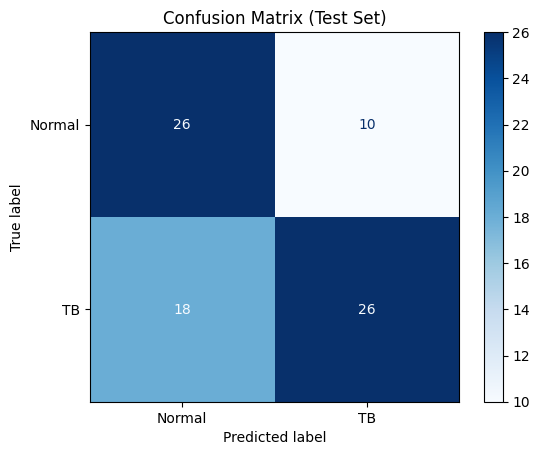


Classification Report - 
              precision    recall  f1-score   support

      Normal       0.59      0.72      0.65        36
          TB       0.72      0.59      0.65        44

    accuracy                           0.65        80
   macro avg       0.66      0.66      0.65        80
weighted avg       0.66      0.65      0.65        80



In [12]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

def test_model(model, test_loader):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()

    preds = []
    labels = []

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            _, p = out.max(1)
            preds.extend(p.cpu().numpy())
            labels.extend(y.cpu().numpy())

    # Accuracy
    acc = sum([p==l for p,l in zip(preds, labels)]) / len(labels) * 100
    print(f"\n Final Test Accuracy on 10% Test Splitted data - {acc:.2f}%\n")

    # Confusion Matrix
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal","TB"])
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix (Test Set)")
    plt.show()

    # Classification Report
    print("\nClassification Report - ")
    print(classification_report(labels, preds, target_names=["Normal","TB"]))

test_model(model, test_loader)